<a href="https://colab.research.google.com/github/mrinmoy-sadhukhan/AI_Flower/blob/main/Flower_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

In [ ]:
!ls

drive  sample_data


In [ ]:
!pip install keras-applications

     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

## Load data

In [ ]:
%cd /content/drive/My Drive/kaggle
!pwd

/content/drive/My Drive/kaggle
/content/drive/My Drive/kaggle


#### Extract files from zip file

In [ ]:
! pip install -q kaggle
from google.colab import files


In [ ]:
pwd

'/content/drive/My Drive/kaggle'

Drive path should be changed

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"
#!kaggle datasets download --force -d alxmamaev/flowers-recognition

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/kaggle/flowers-recognition.zip', 'r')
zip_ref.extractall('unzippeed_folder') # unzip directory
zip_ref.close()

In [ ]:
# base_path = 'Dataset/flowers/'
base_path = 'unzippeed_folder/flowers/'
# daisy：菊花。 dandelion：蒲公英。 rose：玫瑰。 sunflower：向日葵。 tulip：郁金香。
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#### Load file names

In [ ]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [ ]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


#### Load images

In [ ]:
print(fnames)

[['unzippeed_folder/flowers/daisy/100080576_f52e8ee070_n.jpg', 'unzippeed_folder/flowers/daisy/10140303196_b88d3d6cec.jpg', 'unzippeed_folder/flowers/daisy/102841525_bd6628ae3c.jpg', 'unzippeed_folder/flowers/daisy/10172567486_2748826a8b.jpg', 'unzippeed_folder/flowers/daisy/10172379554_b296050f82_n.jpg', 'unzippeed_folder/flowers/daisy/10172636503_21bededa75_n.jpg', 'unzippeed_folder/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg', 'unzippeed_folder/flowers/daisy/10437929963_bc13eebe0c.jpg', 'unzippeed_folder/flowers/daisy/10300722094_28fa978807_n.jpg', 'unzippeed_folder/flowers/daisy/10391248763_1d16681106_n.jpg', 'unzippeed_folder/flowers/daisy/1031799732_e7f4008c03.jpg', 'unzippeed_folder/flowers/daisy/10437754174_22ec990b77_m.jpg', 'unzippeed_folder/flowers/daisy/10466558316_a7198b87e2.jpg', 'unzippeed_folder/flowers/daisy/10466290366_cc72e33532.jpg', 'unzippeed_folder/flowers/daisy/10555749515_13a12a026e.jpg', 'unzippeed_folder/flowers/daisy/10555815624_dc211569b0.jpg', 'unzippeed_fo

In [ ]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [ ]:
print(images)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [769, 1052, 784, 734, 984]


#### Calculate the minimal shape for all images

In [ ]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


#### Create a function to convert cv2 BGR format to RGB for showing

In [ ]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

#### Show sample images for all flowers

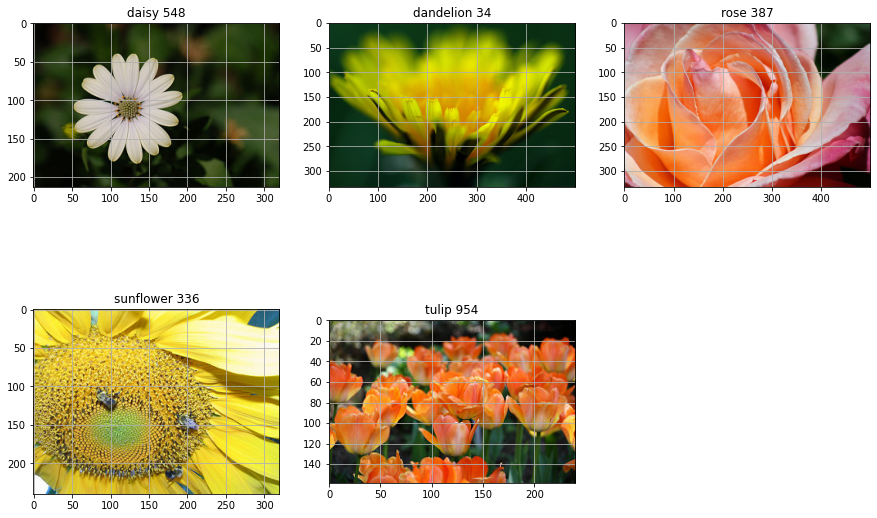

In [ ]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

#### Resize all the images to 256x256

(333, 500, 3)
(256, 256, 3)


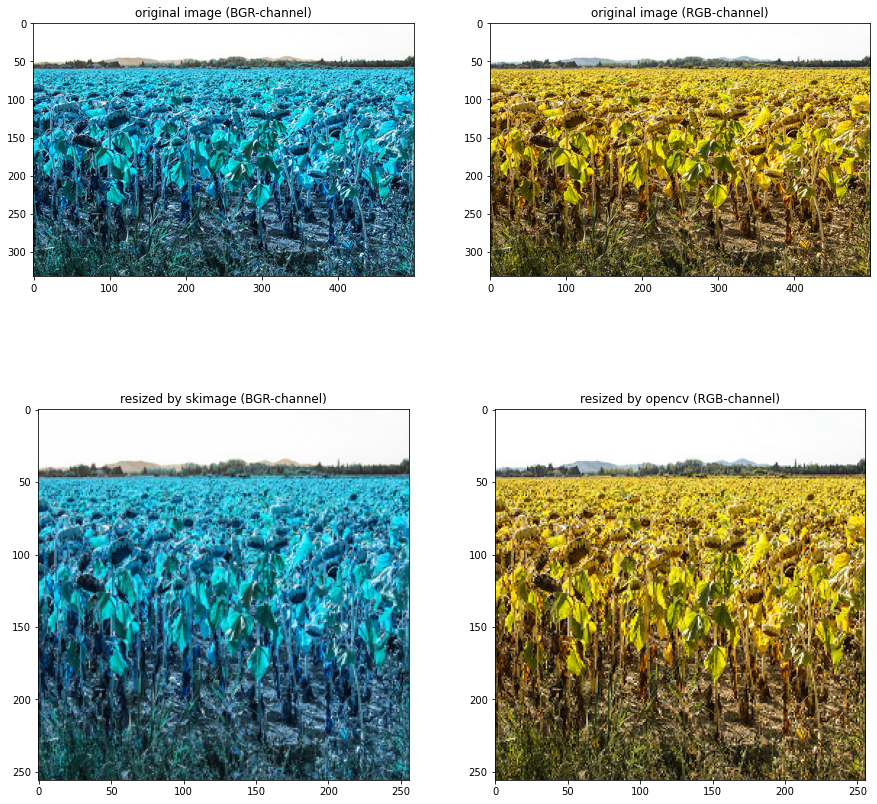

In [ ]:
img_width, img_height = 256, 256

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [ ]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

#### Split dataset to 80% of training and 20% of validation 

In [ ]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

#### Creat labels

In [ ]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[615, 841, 627, 587, 787]
sum of train images: 3457
[154, 211, 157, 147, 197]
sum of val_images: 866


#### Convert image data to numpy array
Convert and pre-processing

convert class labels to binary class labels

In [ ]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [ ]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3457, 256, 256, 3)
train labels: (3457,)

After converting
train data: (3457, 256, 256, 3)
train labels: (3457, 5)


In [ ]:
print(train_categories)

[0 0 0 ... 4 4 4]


#### Shuffle the dataset (set a seed and randomize both the data and the labels)

In [ ]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [ ]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 256, 256, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 256, 256, 3)
shape of val labels: (860, 5)


In [ ]:
print(train_labels)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


## Build the model

In [ ]:
WEIGHTS_PATH_NO_TOP = '/content/drive/My Drive/kaggle/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [ ]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
def create_model_from_VGG19():
    """
      use VGG19
    """
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
    
    # Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)
    
    # creating the final model 
    final_model = Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return final_model

In [ ]:
def create_model_from_ResNet50():

    """
     Use ResNet-50 (this model's code is from https://www.kaggle.com/cokastefan/keras-resnet-50)
    """
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 254, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 127, 127, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0

In [ ]:
model_VGG19 = create_model_from_VGG19()
model_VGG19.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_______________________________________________________

In [ ]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________

## Prepare input data

In [ ]:
# Parameters
batch_size = 64
epochs1 = 50
epochs2 = 10
epochs3 = 50

#### Create generator

In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

## Train the model

#### Fit the model with generator

In [ ]:
start = time.time()

model_scratch_info = model_scratch.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs1) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
107/106 - 53s - loss: 1.6619 - acc: 0.2447 - val_loss: 1.5370 - val_acc: 0.3093
Epoch 2/50
107/106 - 52s - loss: 1.4908 - acc: 0.2882 - val_loss: 1.4652 - val_acc: 0.2953
Epoch 3/50
107/106 - 52s - loss: 1.4529 - acc: 0.3047 - val_loss: 1.4171 - val_acc: 0.3535
Epoch 4/50
107/106 - 52s - loss: 1.2891 - acc: 0.4526 - val_loss: 1.1061 - val_acc: 0.5616
Epoch 5/50
107/106 - 52s - loss: 1.1864 - acc: 0.5179 - val_loss: 1.0450 - val_acc: 0.5663
Epoch 6/50
107/106 - 52s - loss: 1.0856 - acc: 0.5600 - val_loss: 0.9552 - val_acc: 0.6221
Epoch 7/50
107/106 - 52s - loss: 1.0792 - acc: 0.5571 - val_loss: 0.9568 - val_acc: 0.6174
Epoch 8/50
107/106 - 52s - loss: 1.0458 - acc: 0.5856 - val_loss: 0.9653 - val_acc: 0.6233
Epoch 9/50
107/106 - 52s - loss: 1.0215 - acc: 0.6029 - val_loss: 0.9551 - val_acc: 0.6395
Epoch 10/50
107/106 - 52s - loss: 0.9983 - acc: 0.6091 - val_loss: 0.9395 - val_acc: 0.6384
Epoch 11/50
1

In [ ]:
model_scratch.save('/content/drive/MyDrive/kaggle/scratch_train.h5')

In [ ]:
start = time.time()

model_VGG19_info = model_VGG19.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs2, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator,
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_VGG19 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs2) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
107/106 - 79s - loss: 1.9557 - acc: 0.2341 - val_loss: 1.5992 - val_acc: 0.2442
Epoch 2/10
107/106 - 77s - loss: 1.5999 - acc: 0.2429 - val_loss: 1.5997 - val_acc: 0.2442
Epoch 3/10
107/106 - 76s - loss: 1.5998 - acc: 0.2450 - val_loss: 1.5995 - val_acc: 0.2442
Epoch 4/10
107/106 - 75s - loss: 1.6000 - acc: 0.2324 - val_loss: 1.5992 - val_acc: 0.2442
Epoch 5/10
107/106 - 75s - loss: 1.6001 - acc: 0.2438 - val_loss: 1.5990 - val_acc: 0.2442
Epoch 6/10
107/106 - 74s - loss: 1.5999 - acc: 0.2441 - val_loss: 1.5994 - val_acc: 0.2442
Epoch 7/10
107/106 - 74s - loss: 1.6002 - acc: 0.2426 - val_loss: 1.5991 - val_acc: 0.2442
Epoch 8/10
107/106 - 73s - loss: 1.5994 - acc: 0.2438 - val_loss: 1.5991 - val_acc: 0.2442
Epoch 9/10
107/106 - 73s - loss: 1.5999 - acc: 0.2435 - val_loss: 1.5993 - val_acc: 0.2442
Epoch 10/10
107/106 - 73s - loss: 1.5992 - acc: 0.2412 - val_loss: 1.5991 - val_acc: 0.2442

 model_VGG19

Saving each **model**

>Scratch Model,
>VGG19,
>Resnet50





In [ ]:
!pwd
!ls


/content/drive/My Drive/kaggle
flowers-recognition.zip
kaggle.json
output
resnet50_weights_tf_dim_ordering_tf_kernels.h5.zip
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5.zip
test
unzippeed_folder
VGG19_train.h5


In [ ]:
model_VGG19.save('/content/drive/MyDrive/kaggle/VGG19_train.h5')

In [ ]:
start = time.time()

model_ResNet50_info = model_ResNet50.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs3, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs3) )

Epoch 1/50
54/53 - 28s - loss: 2.4374 - acc: 0.3063 - val_loss: 1.7379 - val_acc: 0.2567
Epoch 2/50
54/53 - 27s - loss: 1.5400 - acc: 0.3733 - val_loss: 1.6113 - val_acc: 0.2567
Epoch 3/50
54/53 - 28s - loss: 1.4820 - acc: 0.3981 - val_loss: 1.7186 - val_acc: 0.2612
Epoch 4/50
54/53 - 27s - loss: 1.4684 - acc: 0.4057 - val_loss: 1.7104 - val_acc: 0.2656
Epoch 5/50
54/53 - 27s - loss: 1.4338 - acc: 0.4325 - val_loss: 1.6591 - val_acc: 0.2679
Epoch 6/50
54/53 - 27s - loss: 1.3264 - acc: 0.4734 - val_loss: 1.4422 - val_acc: 0.3281
Epoch 7/50
54/53 - 27s - loss: 1.3906 - acc: 0.4514 - val_loss: 1.3698 - val_acc: 0.4464
Epoch 8/50
54/53 - 27s - loss: 1.3591 - acc: 0.4531 - val_loss: 1.5312 - val_acc: 0.4040
Epoch 9/50
54/53 - 27s - loss: 1.3723 - acc: 0.4536 - val_loss: 1.3124 - val_acc: 0.4888
Epoch 10/50
54/53 - 26s - loss: 1.3142 - acc: 0.4707 - val_loss: 1.2208 - val_acc: 0.5246
Epoch 11/50
54/53 - 27s - loss: 1.3044 - acc: 0.4873 - val_loss: 1.1795 - val_acc: 0.5625
Epoch 12/50
54/53 -

In [ ]:
model_ResNet50.save('/content/drive/MyDrive/kaggle/resnet50_train.h5')

In [ ]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [ ]:
# plt.figure(figsize=(15,15))
# # indexs = [10, 20, 30, 40, 50, 60, ]
# for i in range(9):
#   idx = np.random.randint(860)
#   plt.subplot(3,3,i+1)
#   plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
#   category_idx = return_name(val_labels[idx])
#   plt.title(categories[category_idx])
#   plt.grid('off')
# plt.show()

## Predict and evaluate the model

In [ ]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

model_scratch


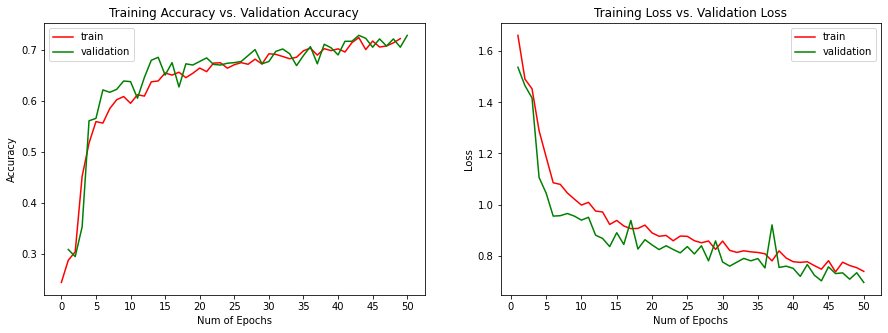

model_VGG19


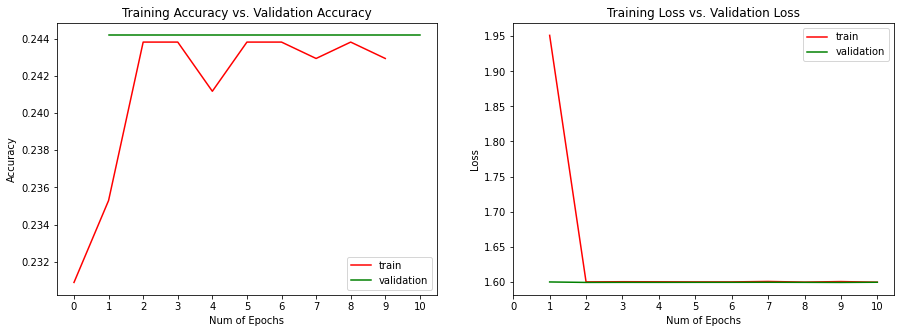

In [ ]:
plot_model_history('model_scratch', model_scratch_info.history, epochs1)
plot_model_history('model_VGG19', model_VGG19_info.history, epochs2)
plot_model_history('model_ResNet50', model_ResNet50_info.history, epochs3)

#### Predict one image

In [ ]:
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('/content/drive/MyDrive/kaggle/test/27465811_9477c9d044.jpg')
pred, probability = predict_one_image(test_img, model_ResNet50)
#pred, probability = predict_one_image(test_img, model_VGG19)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

dandelion 23%


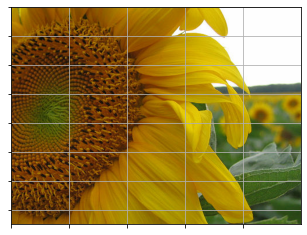

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('/content/drive/MyDrive/kaggle/test/27465811_9477c9d044.jpg')
#pred, probability = predict_one_image(test_img, model_ResNet50)
pred, probability = predict_one_image(test_img, model_VGG19)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('/content/drive/MyDrive/kaggle/test/27465811_9477c9d044.jpg')
#pred, probability = predict_one_image(test_img, model_ResNet50)
pred, probability = predict_one_image(test_img, model_scratch)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [ ]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

### **iterate randomly in different picture to predict the class**

In [ ]:
print("Model trained from ResNet-50")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model_ResNet50)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
pip install imutils

## **Bounding Box and Image Pyramid for predicting multiple flowers in a image.Here We use simple machine learning technique for Bounding BOX**

In [ ]:
# import the necessary packages
import imutils
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
#import argparse
import time
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True, help="Path to the image")
#args = vars(ap.parse_args())
# load the image and define the window width and height
model=load_model('/content/drive/MyDrive/kaggle/resnet50_train.h5')
image = cv2.imread('/content/drive/MyDrive/kaggle/test/beautiful-flower-yellow-sunflower-red-600w.jpg')
(winW, winH) = (200,200) #it can be changed to see different result
for resized in pyramid(image, scale=1.5):
	# loop over the sliding window for each layer of the pyramid
	for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
		# if the window does not meet our desired window size, ignore it
		if window.shape[0] != winH or window.shape[1] != winW:
			continue
		# THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
		# MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
		# WINDOW
		# since we do not have a classifier, we'll just draw the window
			# the region using Keras/TensorFlow
		img_width , img_height = 256,256
		INPUT_SIZE=(256,256)
		roi = cv2.resize(window, INPUT_SIZE)
		#cv2_imshow(roi)
		#roi = img_to_array(roi)
		#roi = preprocess_input(roi)
		#rois = np.array(roi, dtype="float32")
		img = np.reshape(roi, (1, img_width, img_height, 3))
		val_input = img/255.
		pred = model.predict(val_input)
		#print(pred)
		class_num = np.argmax(pred)
		#print(class_num)
		#print(window)
		#print(rois.shape)
		prob=np.max(pred)
		pred=class_num
		clone = resized.copy()
		if prob>=0.8:
			print('Predict:%s %d%%' % (categories[pred], round(prob, 2)*100))
			
			cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255, 255, 0), 2) #(0.255,0) means color code
			cv2_imshow(clone)
		cv2.waitKey(1)
	time.sleep(0.025)